# Understanding Black-Box Chess Agents
This notebook generates saliency maps for a move played by the stockfish engine. The saliency maps give an insight to the tactic behind a particular move.

In [64]:
import chess #version: 0.27.3
import chess.uci
import chess.pgn
import sys
import math
import matplotlib.pyplot as plt
import copy
import cairosvg
import cv2
import time
import numpy as np
import svg_custom.svg_custom as svg_custom # use chess.svg if you don't want the board in B/W

# load your engine:
handler = chess.uci.InfoHandler()
engine = chess.uci.popen_engine('path to the stockfish engine') #give path to your engine here
engine.info_handlers.append(handler)
# board


In [65]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def your_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def your_entropy(q_vals):
    entropy_q = [i*math.log(i)/math.log(2) for i in q_vals]
    entropy = sum(entropy_q)*-1
    return entropy

def return_q_vals(board, legal_moves, eval_time=100):
    """
    This function calculates Q-values of every move for the given board.
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
    Output:
        q_vals: np array of Q values of required moves
        max_move: chess.Move() - Best move in perturbed state
        second_max_move: chess.Move() - Second best move in perturbed state
        """
    i = 0
    q_vals = []
    
    maxq = -100000000
    second_maxq = -100000000
    max_move = None
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            q_vals.append(score)
            
            if(score > maxq):
                
                second_maxq = maxq
                maxq = score
                
                second_max_move = max_move
                max_move = el
            
            elif(score > second_maxq and score != maxq):
                second_maxq = score
                second_max_move = el

    return np.asarray(q_vals), max_move, second_max_move

def return_moves_vals(board, legal_moves, eval_time):
    """Returns the moves except for the original move"""
        
    i = 0
    q_vals_dict = {}
    q_vals = []
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
#             score = 0.
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            q_vals_dict[el.uci()] = score
            q_vals.append(score)
            
    return q_vals_dict, np.array(q_vals) 
def moves_q_vals(board, legal_moves, eval_time, original_move):
    """
    This function returns a dictionary of Q-values for every move.
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
        original_move: original best move (chess.Move()) 
    Output:
        q_vals_dict: Dictionary of move with respective Q-value
        q_vals: np array of Q values of required moves
        max_move: chess.Move() - Best move in perturbed state
        second_max_move: chess.Move() - Second best move in perturbed state
    """
    
    i = 0
    q_vals_dict = {}
    q_vals = []
    
    maxq = -100000000
    second_maxq = -100000000
    max_move = None
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
#             score = 0.
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            if el != original_move:
                q_vals_dict[el.uci()] = score
            q_vals.append(score)
            if(score > maxq):
                
                second_maxq = maxq
                maxq = score
                
                second_max_move = max_move
                max_move = el
            
            elif(score > second_maxq and score != maxq):
                second_maxq = score
                second_max_move = el

    return q_vals_dict, np.asarray(q_vals), max_move, second_max_move


def heat_policy_atari(dictP, dictQ):
    """
    This function calculates L2-norm of 2 policies
    Input:
        dictP: Policy 1 dictionary of moves with Q-values
        dictQ: Policy 2 dictionary of moves with Q-values
    """
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    dic = dictP.copy()
    dic.update(dictQ)
    for move in dic:
        if move in dictP:
            Q_p.append(dictP[move])
        else:
            Q_p.append(0.)
        if move in dictQ:
            Q_q.append(dictQ[move])
        else:
            Q_q.append(0.)
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    
    S = np.linalg.norm(Q_q - Q_p)

    return S


def cross_entropy(dictP, dictQ):
    """
    This function calculates normalized cross entropy (KL divergence) of Q-values of state Q wrt state P.
    Input:
        dictP: Q-value dictionary of perturbed state
        dictQ: Q-value dictionary of original state
    Output:p = policy[:best_move+1]
    p = np.append(p, policy[best_move+1:])

        K: normalized cross entropy
    """
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    for move in dictP:
        if move in dictQ:
            Q_p.append(dictP[move])
            Q_q.append(dictQ[move])
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    KL = entropy(Q_q, Q_p)
    return 1./(KL + 1.)


# Generate saliency maps using our cross-entropy method
We took 15 board positions from lichess.com and explained them using saliency maps. These maps are overlaid onto the chess board for ease of interpretation.

You can load your own board positions (fen notation) by changing board_configs.

**Note: <br>
    Change save path of maps <br>
    This code works for board positions where it is white's turn. See stockfish's evaluation documentation to modify it to work correctly for black's turn**

*********************** gen2 **********************
Total Legal Moves :  34
---------------------------------------------------
First few moves (at most 3) are:
c3e4 3.81
a2a3 2.75
e2b5 2.43
Move number: 0
Score: 0.2844375492987333
Total Legal Moves :  32
Delta P =  0.13792822050818757
KL normalized =  0.8671267959802247
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  26
Delta P =  0.19006550931268687
KL normalized =  0.6084713281745852
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.21701380662322317
KL normalized =  0.8733036970193121
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.16517464543093435
KL normalized =  0.37402729176023375
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  32
Delta P =  -0.01132411565851793
KL normalized =  0.7179616723596679
Removed P f

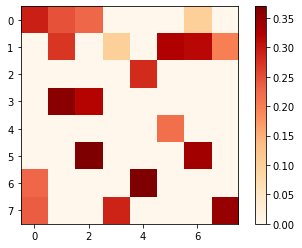

Move number: 1
Score: 0.0985450416305883
Total Legal Moves :  32
Delta P =  0.040059082052806984
KL normalized =  0.7089803459341877
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  26
Delta P =  0.0514231547323393
KL normalized =  0.609258486648107
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.01619441153089482
KL normalized =  0.7162525092059412
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.049816861375712174
KL normalized =  0.7907269022724
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.036681776345891814
KL normalized =  0.893029864526417
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  27
Delta P =  -0.016279294162580588
KL normalized =  0.6449514419552488
Removed B from position: (1, 4)
-------

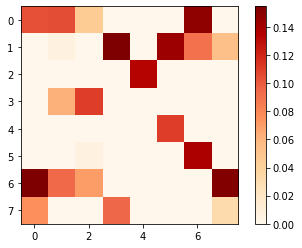

Move number: 2
Score: 0.0715583870884385
Total Legal Moves :  32
Delta P =  -0.02169939881990647
KL normalized =  0.6960086283142657
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  26
Delta P =  -0.0374549068098077
KL normalized =  0.6283859121034846
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  32
Delta P =  -0.03769598426703191
KL normalized =  0.7216340683735065
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  32
Delta P =  -0.022353789262393634
KL normalized =  0.4302784720893185
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  32
Delta P =  -0.003338238288893236
KL normalized =  0.7488061729520048
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.012212716433618327
KL normalized =  0.9035531780052773
Removed P from position: (1, 2)

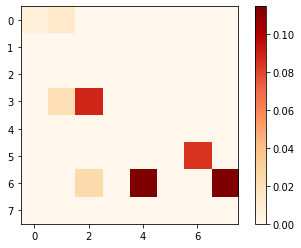

In [68]:
######################## heatmaps for cross entropy method
    
board_configs = {}
board_configs['gen2'] = 'rqb1k1r1/1p1p1pPp/4p3/1pb5/5P2/2N3P1/PPP1B2P/R2QK2R w KQq - 1 15'
board_configs['gen1'] = 'rqb1k1r1/1p1pbpPp/4p3/1p6/4NP2/6P1/PPP1B2P/R2QK2R w KQq - 3 16'
board_configs['queen_trap'] = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board_configs['queen_fork'] = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'
board_configs['bishop_takes_rook'] = 'rnbqk1nr/1p3ppp/4p3/2bp4/8/p3PN2/1BP2PPP/RN1QKB1R w - - 0 1'
board_configs['pawn_takes_bishop'] = '1k3r2/p6p/2p1Bp2/4p3/1b1pP3/3P2P1/P1K4P/5R2 w - - 0 1'
board_configs['showdown'] = 'rn1qk1nr/p1pp1ppp/1pb1p3/8/2BQ4/2P2N2/PPP2PPP/R1B2RK1 w - - 0 1'
board_configs['rook_captures_queen'] = 'r1r5/2k3pp/2p2p2/1pR1pq2/PQ1n4/3P4/1P4PP/1KRB4 w - - 0 1'
board_configs['knight_captures_queen'] = 'r2r4/1kp2p1p/1q2b1p1/R7/Q7/P1N5/1PP4P/1K5R w - - 0 1'
board_configs['rook_up'] = '4r1k1/1R4p1/4qp1p/8/3r4/1Q3R1P/6P1/7K w - - 0 1'
board_configs['queen_exchange'] = '2kr3r/bbqp1pp1/p3p3/1p2n3/1P1NPBnp/P2B2QP/2P1NPP1/R1R3K1 w - - 0 1'
board_configs['discover_attack'] = '1r6/pkp2p1p/5b2/5p2/5P2/q1PP4/2R1N2P/1K4Q1 w - - 0 1'
board_configs['standoff'] = '1kr5/pr4p1/5n1p/5p2/3P4/qbR2P1P/B2Q1NP1/K6R w - - 0 1'
board_configs['rook_takes_bishop'] = '1kr2b1r/1pq2bpp/p3np2/2p1p3/4P3/2N1BPN1/PPPR1QPP/1K1R4 w - - 0 1'
board_configs['bishop_takes_queen'] = '5rk1/p1q2ppp/1p2p1n1/2p1r2Q/2P5/3B4/PP3PPP/3RR1K1 w - - 0 1'
board_configs['bishop_up'] = '4rrk1/pp1qp1bp/2pnbpp1/8/3PNP2/2PB4/PP2Q1PP/R1B2RK1 w - - 0 1'
board_configs['bishop_fork'] = '2b1r1k1/2q1bppp/2p3n1/r1B1p3/N3n3/5N2/P3BPPP/2RQ1RK1 w - - 0 1'

for board_name in board_configs:
    print("***********************", board_name, "**********************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    evaltime = 100
    
    # set original state 
    engine.position(board)
    evaluation = engine.go(movetime=evaltime)
    original_move = evaluation.bestmove

    legal_moves = list(board.legal_moves)[:]

    
    # Q-values for original state
    q_vals_dict_og, q_vals  = return_moves_vals(board, legal_moves, evaltime)
    sorted_moves_list = sorted(q_vals_dict_og, key = q_vals_dict_og.get, reverse = True)
    sorted_q_vals_list = sorted(q_vals, reverse = True)

    
#     # probability of moves in the original state
    old_scores_list = np.exp(sorted_q_vals_list)/np.sum(np.exp(sorted_q_vals_list))

    # policy of original state
#     softmax = your_softmax(q_vals)
#     entropy_og = entropy(softmax)

#     print("Original score (Initial probability of best action): ", old_score)
#     print("Original value : ", max(q_vals))
#     print("Best Move is ", original_move)
    print('---------------------------------------------------')
    print('First few moves (at most 3) are:')
    for i in range(min(3, len(legal_moves))):
        print(sorted_moves_list[i], sorted_q_vals_list[i])

    for move_idx in range(min(3, len(legal_moves))):
        print('Move number:', move_idx)
        print('Score:', old_scores_list[move_idx])
        old_score = old_scores_list[move_idx]
        original_move = chess.Move.from_uci(sorted_moves_list[move_idx])
        
        heatmap = np.zeros((8, 8))

        entropy_map = np.zeros((8,8))

        for i in range(64):
            h = i//8 
            w = i%8

            # perturb board
            piece_removed = board.remove_piece_at(i)

            # Evaluate the board on the basis of the value
            if piece_removed is not None:

                # If king is removed or if board position is illegal set it back 
                if (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
                    board.set_piece_at(i, piece_removed)
                else:
                    # set perturbed state
                    engine.position(board)

                    # Check if the original move is still valid
                    if board.is_legal(original_move):

                        # Find the index of the original move in the list of legal moves
                        j = 0
                        original_move_index = 0
                        for el in legal_moves:
                            if el in board.legal_moves:
                                if(el == original_move):
                                    original_move_index = j
                                j+=1

                        # Find the q values 
                        q_vals_dict_new, q_vals, new_best_move, new_second_best_move = moves_q_vals(board, legal_moves, evaltime, original_move)

                        # probability of original move in perturbed state
                        new_score = np.exp(q_vals[original_move_index])/np.sum(np.exp(q_vals))

                        new_q = q_vals[original_move_index]

                        K = cross_entropy(q_vals_dict_new, q_vals_dict_og)

                        dP = old_score - new_score

                        if new_score < old_score: # harmonic mean
                            heatmap[h, w] = 2*dP*K/(dP + K)
                        else:
                            heatmap[h, w] = 0.

                        print("Delta P = ", dP)
                        print("KL normalized = ", K)
                        print('Removed', piece_removed, 'from position:', (h, w))
                        print('------------------------------------------')

                    else:
                        # illegal original move in perturbed state
                        heatmap[h, w] = -1.

                    # undo perturbation
                    board.set_piece_at(i, piece_removed)

        heatmap = np.flipud(heatmap)


        # If original move is not valid, give highest value in the heat map
        heatmap[heatmap == -1] = np.max(heatmap)



        ### Original Saliency Map (without overlay onto board)

        plt.figure(1)
        plt.imshow(heatmap, cmap='OrRd')
        plt.colorbar()
        plt.savefig('results/entropy/map_'+board_name+ str(move_idx) + '.png')
        plt.show()    


        #### Saliency map overlaid on board

        svg = svg_custom.board(board) 
        with open('board.svg', 'w+') as f:
            f.write(svg)
        cairosvg.svg2png(url='board.svg', write_to='board.png')

        # original board as a numpy array
        board_array = cv2.imread('board.png')

        threshold = (100/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board

        # Create bounding boxes with saliency colours for every square on chess board
        for i in range(0, 8, 1):
            for j in range(0, 8, 1):
                ii = 45*i+20
                jj = 45*j+20
                value_of_square =  heatmap[i, j]
                if value_of_square < threshold:
                    continue
                for box_i in range(ii, ii+44, 1):
                    for box_j in range(jj, jj+44, 1):
                        if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                            continue
                        board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap))
                        board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap))
                        board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap))

        cv2.imwrite("results/entropy/" + board_name + '_Move_' + sorted_moves_list[move_idx] + "_Rank_" + str(move_idx) + ".png",board_array)
    
    break

In [21]:
print(q_vals)

['a3g3', 'f4h6', 'e5d7', 'f4h2', 'c2c3', 'f4g3', 'a3h3', 'e5d3', 'e5g4', 'f2f3', 'd2c1', 'a3f3', 'g1h2', 'a3a1', 'e1c1', 'e1b1', 'e5c4', 'e5f7', 'e1a1', 'e1d1', 'a3d3', 'g1h1', 'e5f3', 'f4g5', 'g2g3', 'a3a4', 'a3b3', 'd2d1', 'e5g6', 'e5c6', 'e1f1', 'f4e3', 'a3e3', 'e1e3', 'a3a2', 'e1e2', 'e1e4', 'a3c3', 'd2d3', 'd2e2', 'd2d4', 'd2c3', 'd2e3'] [5.74, -1.21, -1.7, -2.5, -2.97, -3.0, -3.03, -3.03, -3.37, -3.51, -3.56, -3.6, -3.68, -4.0, -4.05, -4.05, -4.16, -4.19, -4.34, -4.37, -4.49, -4.67, -4.7, -4.81, -4.92, -5.1, -5.77, -7.15, -7.35, -7.64, -8.19, -8.25, -8.33, -8.57, -8.74, -9.02, -9.06, -9.2, -9.53, -12.28, -15.43, -16.18, -17.28, -20.44]


In [22]:
for i, move in enumerate(l):
    if(q_vals_dict_og[move] == q_vals_sorted[i]):
        print(move)
        break
    else:
        print(move, q_vals_sorted[i])

a3g3 5.74
f4h6 -1.21
e5d7 -1.7
f4h2 -2.5
c2c3 -2.97
f4g3 -3.0
a3h3


# Generate Saliency Maps using other methods


In [ ]:
######################## heatmaps for other comparison methods

for board_name in board_configs:
    print("*************************" + board_name + "*****************************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    handler = chess.uci.InfoHandler()
    engine = chess.uci.popen_engine('/home/shripad/Desktop/Shripad/Downloaded_Codes/stockfish-saliency/stockfish-10-linux/Linux/stockfish_10_x64') #give path to your engine here
    engine.info_handlers.append(handler)
    
    engine.position(board)
    evaltime = 100 
    best_evaluation = engine.go(movetime=evaltime)
    
    # V of original state (This is also Q(original state, best action))
    V = handler.info["score"][1].cp/100.0
    move_to_take = [best_evaluation[0]]
    print("Original value : ", V)
    
    # V-based method
    heatmap = np.zeros((8,8))
    # Q-based method
    heatmapQ = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):
            pos = 8*(7-i) + j
            #perturb board
            piece = board.remove_piece_at(pos)
            
            if piece is None or piece.piece_type is 6 or board.was_into_check() or board.is_legal(move_to_take[0]) is False:
                heatmap[i][j] = 0.
                heatmapQ[i, j] = 0.
            else:
                print("-----------------------------")
                print("Position : ", i, j)
                print("Piece : ", piece)
                
                engine.position(board)
                p_evaluation = engine.go(searchmoves=move_to_take, movetime=evaltime)
                # Q for original move in perturbed state
                if handler.info["score"][1].cp is None:
                    p_Q = handler.info["score"][1].mate
                else:
                    p_Q = handler.info["score"][1].cp/100.0
                
                
                engine.position(board)
                p_evaluation = engine.go(movetime=evaltime)
                # V of perturbed_state
                if handler.info["score"][1].cp is None:
                    p_V = handler.info["score"][1].mate
                else:
                    p_V = handler.info["score"][1].cp/100.0
                print("New Action Value : ", p_Q)
                print("New State Value : ", p_V)
                heatmap[i][j] = pow(V - p_V,2)*0.5
                heatmapQ[i, j] = max(V - p_Q, 0)
                
            board.set_piece_at(pos, piece)
    
    
    
##### Original Saliency maps
    
    plt.figure(1)
    plt.imshow(heatmap, cmap='OrRd')
    plt.savefig('results/value_l2/V_map_' + board_name + '.png')
    
    plt.figure(2)
    plt.imshow(heatmapQ, cmap='OrRd')
    plt.savefig('results/action_value/Q_map_' + board_name + '.png')
    
    
##### Saliency maps on the chess board    
    
    ########## Saving 0.5*(V1 - V2)**2
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    threshold = (80/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board
    
    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap))
    
    cv2.imwrite("results/value_l2/V_" + board_name + ".png" ,board_array)
    
    ############# Saving Q2 - Q1
        
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    threshold = (80/256)*np.max(heatmapQ) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmapQ[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmapQ[i, j]/(np.max(heatmapQ))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmapQ[i, j]/(np.max(heatmapQ))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmapQ[i, j]/(np.max(heatmapQ))
    
    cv2.imwrite("results/action_value/Q_" + board_name + ".png" ,board_array)

    
    

In [ ]:
def heat(dictP, dictQ):
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    dic = dictP.copy()
    dic.update(dictQ)
    for move in dic:
        if move in dictP:
            Q_p.append(dictP[move])
        else:
            Q_p.append(0.)
        if move in dictQ:
            Q_q.append(dictQ[move])
        else:
            Q_q.append(0.)
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    
    S = np.linalg.norm(Q_q - Q_p)

    return S

board_configs = {}
board_configs['queen_trap'] = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board_configs['queen_fork'] = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'
board_configs['bishop_takes_rook'] = 'rnbqk1nr/1p3ppp/4p3/2bp4/8/p3PN2/1BP2PPP/RN1QKB1R w - - 0 1'
board_configs['pawn_takes_bishop'] = '1k3r2/p6p/2p1Bp2/4p3/1b1pP3/3P2P1/P1K4P/5R2 w - - 0 1'
board_configs['showdown'] = 'rn1qk1nr/p1pp1ppp/1pb1p3/8/2BQ4/2P2N2/PPP2PPP/R1B2RK1 w - - 0 1'
board_configs['rook_captures_queen'] = 'r1r5/2k3pp/2p2p2/1pR1pq2/PQ1n4/3P4/1P4PP/1KRB4 w - - 0 1'
board_configs['knight_captures_queen'] = 'r2r4/1kp2p1p/1q2b1p1/R7/Q7/P1N5/1PP4P/1K5R w - - 0 1'
board_configs['rook_up'] = '4r1k1/1R4p1/4qp1p/8/3r4/1Q3R1P/6P1/7K w - - 0 1'
board_configs['queen_exchange'] = '2kr3r/bbqp1pp1/p3p3/1p2n3/1P1NPBnp/P2B2QP/2P1NPP1/R1R3K1 w - - 0 1'
board_configs['discover_attack'] = '1r6/pkp2p1p/5b2/5p2/5P2/q1PP4/2R1N2P/1K4Q1 w - - 0 1'
board_configs['standoff'] = '1kr5/pr4p1/5n1p/5p2/3P4/qbR2P1P/B2Q1NP1/K6R w - - 0 1'
board_configs['rook_takes_bishop'] = '1kr2b1r/1pq2bpp/p3np2/2p1p3/4P3/2N1BPN1/PPPR1QPP/1K1R4 w - - 0 1'
board_configs['bishop_takes_queen'] = '5rk1/p1q2ppp/1p2p1n1/2p1r2Q/2P5/3B4/PP3PPP/3RR1K1 w - - 0 1'
board_configs['bishop_up'] = '4rrk1/pp1qp1bp/2pnbpp1/8/3PNP2/2PB4/PP2Q1PP/R1B2RK1 w - - 0 1'
board_configs['bishop_fork'] = '2b1r1k1/2q1bppp/2p3n1/r1B1p3/N3n3/5N2/P3BPPP/2RQ1RK1 w - - 0 1'

for board_name in board_configs:
    print("***********************", board_name, "**********************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    evaltime = 100
    
    # set original state 
    engine.position(board)
    evaluation = engine.go(movetime=evaltime)
    original_move = evaluation.bestmove

    legal_moves = list(board.legal_moves)[:]

    
    # Q-values for original state
    q_vals_dict_og, q_vals, _,second_best_move  = moves_q_vals(board, legal_moves, evaltime, original_move)

    old_V = np.max(q_vals)

    
    # probability of original_move in original state
    old_score = np.exp(max(q_vals))/np.sum(np.exp(q_vals))

    heatmapV = np.zeros((8, 8))
    heatmapP = np.zeros((8, 8))

    for h in range(8):
        for w in range(8):
        # perturb board
            pos = 8*(7-h) + w
            piece_removed = board.remove_piece_at(pos)

            # Evaluate the board on the basis of the value
            if piece_removed is not None:

                # If king is removed or if board position is illegal set it back 
                if (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
                    board.set_piece_at(pos, piece_removed)
                else:
                    # set perturbed state
                    engine.position(board)

                    # Check if the original move is still valid
                    if board.is_legal(original_move):

                        # Find the index of the original move in the list of legal moves
                        j = 0
                        original_move_index = 0
                        for el in legal_moves:
                            if el in board.legal_moves:
                                if(el == original_move):
                                    original_move_index = j
                                j+=1

                        # Find the q values 
                        q_vals_dict_new, q_vals, new_best_move, new_second_best_move = moves_q_vals(board, legal_moves, evaltime, original_move)

                        # probability of original move in perturbed state
                        new_score = np.exp(q_vals[original_move_index])/np.sum(np.exp(q_vals))

                        new_q = q_vals[original_move_index]
                         
                        new_V = np.max(np.asarray(q_vals))

                        K = heat(q_vals_dict_new, q_vals_dict_og)
                        heatmapV[h,w] = 0.5*(old_V - new_V)**2
                        heatmapP[h, w] = K

                    else:
                        # illegal original move in perturbed state
                        heatmapP[h, w] = -1.
                        heatmapV[h, w] = -1
                    # undo perturbation
                    board.set_piece_at(pos, piece_removed)


    # If original move is not valid, give highest value in the heat map
    heatmapV[heatmapV == -1] = np.max(heatmapV)
    heatmapP[heatmapP == -1] = np.max(heatmapP)

#     heatmap = np.zeros((8,8,3))
#     heatmapV = (heatmapV - np.min(heatmapV))/(np.max(heatmapV) - np.min(heatmapV))
#     heatmapP = (heatmapP - np.min(heatmapP))/(np.max(heatmapP) - np.min(heatmapP))
#     heatmap = np.zeros((8,8))
#     heatmap[heatmapV >= heatmapP] = heatmapV + heatmapP
#     heatmap[heatmapV < heatmapP] = -1.0*(heatmapV + heatmapP)
    
    plt.figure(1)
    plt.imshow(heatmapP, cmap='OrRd')
    plt.savefig('results/value_l2/policy_map_' + board_name + '.png')
    
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    
    threshold = (80/256)*np.max(heatmapP)
    
    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmapP[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmapP[i, j]/(np.max(heatmapP))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmapP[i, j]/(np.max(heatmapP))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmapP[i, j]/(np.max(heatmapP))
    
    cv2.imwrite("results/value_l2/policy_" + board_name + ".png" ,board_array)   